The goal of this notebook is to look at my expenses and income. Maybe I'll turn it into a blog post; probably not.

Schwab only lets me download two years' worth of checking account data, so that's what we're looking at.

In [1]:
import pandas as pd

import matplotlib.pyplot as plt
import seaborn as sns

import matplotlib.dates as mdates

%matplotlib inline

In [2]:
df = pd.read_csv('Schwab_Checking_Checking_Transactions_20210725-102523.CSV')

df.head()

Transactions  for Checking account Schwab Checking XXXXXX-184849 as of 07/25/2021 10:25:24 ET
Date                                               Type Check # Description                     Withdrawal (-) Deposit (+)                                     RunningBalance                                           
Pending Transactions are not reflected within t... NaN  NaN     NaN                             NaN            NaN                                                        NaN                                           
Posted Transactions                                NaN  NaN     NaN                             NaN            NaN                                                        NaN                                           
07/23/2021                                         ACH  NaN     CARDMEMBER SERV WEB PYMT 210722 $1,944.96      NaN                                                $120,189.07                                           
                                                                BK OF AMER MC ONLINE PMT 210723 $25.00         NaN                                                $122,134.03

Ah, annoying there's four rows of non-header info, and the headers are in the second row.

In [3]:
df = pd.read_csv('Schwab_Checking_Checking_Transactions_20210725-102523.CSV', skiprows=1)
df = df.iloc[2:]
df.head()

,Date,Type,Check #,Description,Withdrawal (-),Deposit (+),RunningBalance
2,07/23/2021,ACH,NaN,CARDMEMBER SERV WEB PYMT 210722,"$1,944.96",NaN,"$120,189.07"
3,07/23/2021,ACH,NaN,BK OF AMER MC ONLINE PMT 210723,$25.00,NaN,"$122,134.03"
4,07/21/2021,ACH,NaN,VENMO PAYMENT 210720,$21.20,NaN,"$122,159.03"
5,07/19/2021,ACH,NaN,ALAIN DUVALLE SV POPMONEY 210719,NaN,"$5,000.00","$122,180.23"
6,07/15/2021,ACH,NaN,GUSTO PAYROLL PAY 168597 210715,NaN,"$3,139.16","$117,180.23"


In [5]:
df = df.rename(columns={'Withdrawal (-)': 'withdrawal', 'Deposit (+)': 'deposit', 'Check #': 'check_num'})
df.columns = [i.lower() for i in df.columns]

In [6]:
df.head()

,date,type,check_num,description,withdrawal,deposit,runningbalance
2,07/23/2021,ACH,NaN,CARDMEMBER SERV WEB PYMT 210722,"$1,944.96",NaN,"$120,189.07"
3,07/23/2021,ACH,NaN,BK OF AMER MC ONLINE PMT 210723,$25.00,NaN,"$122,134.03"
4,07/21/2021,ACH,NaN,VENMO PAYMENT 210720,$21.20,NaN,"$122,159.03"
5,07/19/2021,ACH,NaN,ALAIN DUVALLE SV POPMONEY 210719,NaN,"$5,000.00","$122,180.23"
6,07/15/2021,ACH,NaN,GUSTO PAYROLL PAY 168597 210715,NaN,"$3,139.16","$117,180.23"


In [7]:
# Fix the dtypes
df['withdrawal'] = df['withdrawal'].str.strip('$').str.replace(',', '').astype(float)
df['deposit'] = df['deposit'].str.strip('$').str.replace(',', '').astype(float)
df['runningbalance'] = df['runningbalance'].str.strip('$').str.replace(',', '').astype(float)
df.head()

,date,type,check_num,description,withdrawal,deposit,runningbalance
2,07/23/2021,ACH,NaN,CARDMEMBER SERV WEB PYMT 210722,1944.96,NaN,120189.07
3,07/23/2021,ACH,NaN,BK OF AMER MC ONLINE PMT 210723,25.00,NaN,122134.03
4,07/21/2021,ACH,NaN,VENMO PAYMENT 210720,21.20,NaN,122159.03
5,07/19/2021,ACH,NaN,ALAIN DUVALLE SV POPMONEY 210719,NaN,5000.00,122180.23
6,07/15/2021,ACH,NaN,GUSTO PAYROLL PAY 168597 210715,NaN,3139.16,117180.23


In [8]:
# And convert date string to datetime
df['date'] = pd.to_datetime(df['date'])

Next let's add some mappings to help the groupby. We'll want year and month indicators.

In [9]:
df['month'] = df['date'].dt.month
df['year'] = df['date'].dt.year

And now we can sum!

In [10]:
monthly = df.groupby(['year', 'month']).sum()[['withdrawal', 'deposit']].reset_index()
monthly.head()

,year,month,withdrawal,deposit
0,2019,7,316.82,1462.12
1,2019,8,2956.51,4897.21
2,2019,9,2892.13,5229.37
3,2019,10,2554.14,5164.92
4,2019,11,3089.76,4194.30


In [11]:
monthly = monthly.sort_values(by=['year', 'month'], ascending=[True, True])
monthly.head()

,year,month,withdrawal,deposit
0,2019,7,316.82,1462.12
1,2019,8,2956.51,4897.21
2,2019,9,2892.13,5229.37
3,2019,10,2554.14,5164.92
4,2019,11,3089.76,4194.30


In [12]:
# Make a date column for easier plotting (fingers crossed)
monthly['date'] = pd.to_datetime(monthly['year'].astype(str) + '-' + monthly['month'].astype(str))
monthly = monthly.set_index('date')

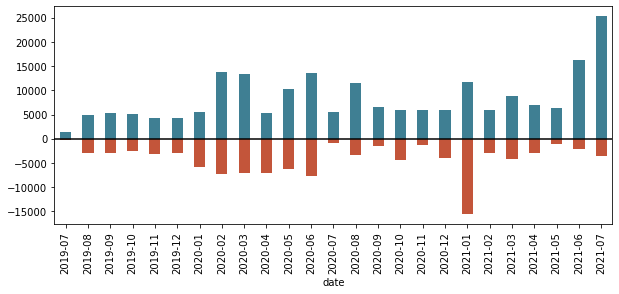

In [13]:
fig, ax = plt.subplots(figsize=(10, 4))

blue = sns.diverging_palette(220, 20)[0]
red = sns.diverging_palette(220, 20)[-1]

# Plot deposits positive
ax = monthly['deposit'].plot(kind='bar', ax=ax, color=blue)

# Plot withdrawals negative
ax = (-1*monthly['withdrawal']).plot(kind='bar', ax=ax, color=red)

# Add horizontal line
ax.axhline(0, c='k')

# 
_ = ax.set_xticklabels(monthly.index.strftime('%Y-%m'))

Ok looking at the revenue first:
- No revenue in May and June 2019. That makes sense, I was on my road trip then. 
- Slight revenue July 2019 -- again, makes sense. I started at Biobot late July.
- Then pretty stable revenue through the end of 2019, around roughly $5000. That was my original Biobot salary.

Let's see what happened in February, March, May, and June of 2020...

In [14]:
# Feb
df.query('date >= "2020-02-01"').query('date < "2020-03-01"')

,date,type,check_num,description,withdrawal,deposit,runningbalance,month,year
210,2020-02-28,INTADJUST,NaN,Interest Paid,NaN,3.21,30423.68,2,2020
211,2020-02-28,ACH,NaN,GUSTO PAY 364988 200228,NaN,2103.98,30420.47,2,2020
212,2020-02-25,ACH,NaN,CARDMEMBER SERV WEB PYMT 200223,15.00,NaN,28316.49,2,2020
213,2020-02-24,ACH,NaN,VENMO PAYMENT,40.00,NaN,28331.49,2,2020
214,2020-02-19,ACH,NaN,Boston Property RESIDENT,5250.00,NaN,28371.49,2,2020
215,2020-02-18,ACH,NaN,VENMO CASHOUT,NaN,2999.00,33621.49,2,2020
216,2020-02-18,ACH,NaN,VENMO CASHOUT,NaN,1468.00,30622.49,2,2020
217,2020-02-18,ACH,NaN,GUSTO PAY 309760 200218,NaN,2103.98,29154.49,2,2020
218,2020-02-10,ACH,NaN,CITI CARD ONLINE PAYMENT 200209,878.86,NaN,27050.51,2,2020
219,2020-02-06,ATM,NaN,7ELEVEN-FCTI 600 TECHNO CAMBRIDGE,60.00,NaN,27929.37,2,2020


Ok so two things happened in February:
- I cashed out my Venmo. I think this was when I started paying rent for the house (my roommate Andee moved out in March, and I took over from her then). Our total rent was $5250, so that means I would have gotten $4200 from my housemates. I use Venmo for other things, so 2999+1468 = 4,467. Ok so there's an extra ~$200 in there, dunno where that would come from. Probably left over from other things.
- My dad gave me part of the car money.

In [15]:
# March
df.query('date >= "2020-03-01"').query('date < "2020-04-01"')

,date,type,check_num,description,withdrawal,deposit,runningbalance,month,year
193,2020-03-31,INTADJUST,NaN,Interest Paid,NaN,2.31,36902.87,3,2020
194,2020-03-31,ATMREBATE,NaN,ATM Fee Rebate,NaN,3.25,36900.56,3,2020
195,2020-03-31,ACH,NaN,CARDMEMBER SERV WEB PYMT 200329,21.14,NaN,36897.31,3,2020
196,2020-03-31,ACH,NaN,GUSTO PAY 507925 200331,NaN,2103.98,36918.45,3,2020
197,2020-03-30,ACH,NaN,CITI CARD ONLINE PAYMENT 200329,993.08,NaN,34814.47,3,2020
198,2020-03-23,ACH,NaN,VENMO PAYMENT,15.00,NaN,35807.55,3,2020
199,2020-03-22,ATM,NaN,USAACATM19 219 CAMBRIDG ALLSTON,403.25,NaN,35822.55,3,2020
200,2020-03-19,ACH,NaN,Boston Property RESIDENT,5250.00,NaN,36225.80,3,2020
201,2020-03-19,ACH,NaN,VENMO CASHOUT,NaN,2999.00,41475.80,3,2020
202,2020-03-19,ACH,NaN,VENMO CASHOUT,NaN,1253.20,38476.80,3,2020


Same thing in March - rent and car money explain it.

What's the deal with April then? Maybe I didn't cash out my venmo till May and June...?

In [16]:
# April
df.query('date >= "2020-04-01"').query('date < "2020-05-01"')

,date,type,check_num,description,withdrawal,deposit,runningbalance,month,year
184,2020-04-30,INTADJUST,NaN,Interest Paid,NaN,0.89,35310.33,4,2020
185,2020-04-30,ACH,NaN,GUSTO PAY 617713 200430,NaN,2101.98,35309.44,4,2020
186,2020-04-28,ACH,NaN,CARDMEMBER SERV WEB PYMT 200427,15.00,NaN,33207.46,4,2020
187,2020-04-23,ACH,NaN,Boston Property RESIDENT,5250.00,NaN,33222.46,4,2020
188,2020-04-15,ACH,NaN,GUSTO PAY 570415 200415,NaN,2103.98,38472.46,4,2020
189,2020-04-15,ACH,NaN,IRS TREAS 310 TAX REF 041520~ Tran: ACH,NaN,1200.00,36368.48,4,2020
190,2020-04-07,ACH,NaN,CITI CARD ONLINE PAYMENT 200406,1523.67,NaN,35168.48,4,2020
191,2020-04-03,ACH,NaN,BK OF AMER MC ONLINE PMT 200403,110.72,NaN,36692.15,4,2020
192,2020-04-01,TRANSFER,NaN,Funds Transfer to Brokerage -0553,100.00,NaN,36802.87,4,2020


Nice. April was the first stimulus check, $1200.

In [17]:
# May
df.query('date >= "2020-05-01"').query('date < "2020-06-01"')

,date,type,check_num,description,withdrawal,deposit,runningbalance,month,year
174,2020-05-29,INTADJUST,NaN,Interest Paid,NaN,0.95,39247.08,5,2020
175,2020-05-29,ACH,NaN,GUSTO PAY 747446 200529,NaN,2366.10,39246.13,5,2020
176,2020-05-27,ACH,NaN,Boston Property RESIDENT,5250.00,NaN,36880.03,5,2020
177,2020-05-27,ACH,NaN,CARDMEMBER SERV WEB PYMT 200523,15.00,NaN,42130.03,5,2020
178,2020-05-27,ACH,NaN,CITI CARD ONLINE PAYMENT 200526,823.53,NaN,42145.03,5,2020
179,2020-05-15,ACH,NaN,GUSTO PAY 681355 200515,NaN,4866.09,42968.56,5,2020
180,2020-05-14,ACH,NaN,SKYPE COMMUNICATIONS SARL IAT PAYPAL USD,5.00,NaN,38102.47,5,2020
181,2020-05-04,ACH,NaN,VENMO CASHOUT,NaN,2982.86,38107.47,5,2020
182,2020-05-01,TRANSFER,NaN,Funds Transfer to Brokerage -0553,100.00,NaN,35124.61,5,2020
183,2020-05-01,ACH,NaN,BK OF AMER MC ONLINE PMT 200501,85.72,NaN,35224.61,5,2020


Nothing special here. Looks like I did get a slight extra income -- I don't think I'd gotten my raise by then, so maybe this was just a one-time bonus? I think we got one of those last year...

In [18]:
# June
df.query('date >= "2020-06-01"').query('date < "2020-07-01"')

,date,type,check_num,description,withdrawal,deposit,runningbalance,month,year
148,2020-06-30,INTADJUST,NaN,Interest Paid,NaN,1.08,45078.01,6,2020
149,2020-06-30,ACH,NaN,GUSTO PAY 937605 200630,NaN,2366.09,45076.93,6,2020
150,2020-06-24,ACH,NaN,Boston Property RESIDENT,5250.00,NaN,42710.84,6,2020
151,2020-06-24,ACH,NaN,VENMO CASHOUT,NaN,2999.00,47960.84,6,2020
152,2020-06-22,ACH,NaN,VENMO CASHOUT,NaN,2999.00,44961.84,6,2020
153,2020-06-22,ACH,NaN,VENMO CASHOUT,NaN,1296.00,41962.84,6,2020
154,2020-06-15,ACH,NaN,CITI CARD ONLINE PAYMENT 200614,1145.46,NaN,40666.84,6,2020
155,2020-06-15,ACH,NaN,BK OF AMER MC ONLINE PMT 200615,146.82,NaN,41812.30,6,2020
156,2020-06-15,ACH,NaN,GUSTO PAY 833163 200615,NaN,2366.08,41959.12,6,2020
157,2020-06-12,VISA,NaN,FAMILIES FOR JUSTI617-9927185 MA #00000,100.00,NaN,39593.04,6,2020


All those paypal transfers are donations to a variety of racial and social justices organizations. This was me redistributing my stimulus check in June, after the murder of George Floyd.

Ah and I see some extra venmo cashout here. So maybe this is for May and June? Let's just remove double housemate-rent from this month.

In [19]:
# July
df.query('date >= "2020-07-01"').query('date < "2020-08-01"')

,date,type,check_num,description,withdrawal,deposit,runningbalance,month,year
140,2020-07-31,INTADJUST,NaN,Interest Paid,NaN,1.17,49774.46,7,2020
141,2020-07-31,ACH,NaN,GUSTO PAY 155581 200731,NaN,3206.17,49773.29,7,2020
142,2020-07-21,ACH,NaN,CARDMEMBER SERV WEB PYMT 200719,497.31,NaN,46567.12,7,2020
143,2020-07-20,ACH,NaN,TEEMILL TECH LTD IAT PAYPAL USDUSD,33.96,NaN,47064.43,7,2020
144,2020-07-15,ACH,NaN,GUSTO PAY 041639 200715,NaN,2366.10,47098.39,7,2020
145,2020-07-06,ACH,NaN,CARDMEMBER SERV WEB PYMT 200703,160.00,NaN,44732.29,7,2020
146,2020-07-06,ACH,NaN,BK OF AMER MC ONLINE PMT 200706,85.72,NaN,44892.29,7,2020
147,2020-07-01,TRANSFER,NaN,Funds Transfer to Brokerage -0553,100.00,NaN,44978.01,7,2020


July looks normal. Though I don't see my venmo cashout... I also didn't pay rent that month. OH that's because we switched it to our housemate, probably...?

In [28]:
# August
df.query('date >= "2020-08-01"').query('date < "2020-09-01"')

,date,type,check_num,description,withdrawal,deposit,runningbalance,month,year
130,2020-08-31,INTADJUST,NaN,Interest Paid,NaN,1.37,57906.37,8,2020
131,2020-08-31,ACH,NaN,CITI AUTOPAY PAYMENT 200828,34.99,NaN,57905.00,8,2020
132,2020-08-31,ACH,NaN,GUSTO PAY 452586 200831,NaN,3206.18,57939.99,8,2020
133,2020-08-25,ACH,NaN,CARDMEMBER SERV WEB PYMT 200824,2277.79,NaN,54733.81,8,2020
134,2020-08-19,ACH,NaN,CITI CARD ONLINE PAYMENT 200818,803.98,NaN,57011.60,8,2020
135,2020-08-19,ACH,NaN,BK OF AMER MC ONLINE PMT 200819,73.96,NaN,57815.58,8,2020
136,2020-08-19,ACH,NaN,IRS TREAS 310 TAX REF 081920~ Tran: ACH,NaN,8.91,57889.54,8,2020
138,2020-08-14,ACH,NaN,GUSTO PAY 362675 200814,NaN,3206.17,52880.63,8,2020
139,2020-08-03,TRANSFER,NaN,Funds Transfer to Brokerage -0553,100.00,NaN,49674.46,8,2020


Ah, got another car transfer in August.

In [29]:
# July 2021
df.query('date >= "2021-07-01"').query('date < "2021-08-01"')

,date,type,check_num,description,withdrawal,deposit,runningbalance,month,year
2,2021-07-23,ACH,NaN,CARDMEMBER SERV WEB PYMT 210722,1944.96,NaN,120189.07,7,2021
3,2021-07-23,ACH,NaN,BK OF AMER MC ONLINE PMT 210723,25.00,NaN,122134.03,7,2021
4,2021-07-21,ACH,NaN,VENMO PAYMENT 210720,21.20,NaN,122159.03,7,2021
6,2021-07-15,ACH,NaN,GUSTO PAYROLL PAY 168597 210715,NaN,3139.16,117180.23,7,2021
7,2021-07-13,ACH,NaN,CARDMEMBER SERV WEB PYMT 210712,537.04,NaN,114041.07,7,2021
8,2021-07-12,ACH,NaN,CITI CARD ONLINE PAYMENT 210711,379.65,NaN,114578.11,7,2021
9,2021-07-12,ACH,NaN,BK OF AMER MC ONLINE PMT 210712,60.72,NaN,114957.76,7,2021
11,2021-07-06,DEPOSIT,NaN,Deposit Mobile Banking,NaN,12115.03,110018.48,7,2021
12,2021-07-06,ACH,NaN,BK OF AMER MC ONLINE PMT 210706,60.72,NaN,97903.45,7,2021
13,2021-07-02,ACH,NaN,HONDA PMT 8004579929 B21182,466.65,NaN,97964.17,7,2021


Oh right, my 12k from Truwest.

I paid rent Feb-August 2020. But Feb rent was for the month of March, so I would have paid August rent in July. No, my housemates paid August rent in July bc we had decided to move by then. So I paid rent Feb-June.

- Feb: I paid rent (withdrawal = 5250) and deposited housemate rent (deposit = 4200)
- March: I paid rent (withdrawal = 5250) and deposited housemate rent (deposit = 4200)
- April: I paid rent, but didn't deposite housemate rent
- May: I paid rent, and deposite housemate rent (well, only $3k worth)
- June: I paid rent, and deposited housemate rent (7.3k, which is two month's worth of three housemates). I think one of my housemates paid me late...? Or maybe Ben paid me back through other means not captured on venmo? Anyway, let's just consider this month having two months' worth of house money shenanigans.
- July: I didn't pay rent and didn't deposit housemate rent. This might have been when we switched over to someone else? I think we decided to move out mid-July, but finally moved out early August.

Questions:
- can I negate the rent money I got and paid? Just remove $4,200 from deposit and withdrawal for the period I paid rent?

- let's remove money from my dad from this analysis, description includes "ALAIN DUVALLE CK POPMONEY"

In [30]:
# Recalculate monthly expenses/withdrawals after removing dad's car payments
# and my car down payment

# Remove dad's car payments
df = df.loc[~df['description'].str.contains('ALAIN DUVALLE CK POPMONEY')]
df = df.loc[~df['description'].str.contains('ALAIN DUVALLE')]

# Remove my car payment
df = df.query('withdrawal != 15000')

# Remove my Truwest deposit
df = df.query('deposit != 12115.03')

In [31]:
# Recalculate monthly deposit and withdrawals
monthly = df.groupby(['year', 'month']).sum()[['withdrawal', 'deposit']].reset_index()
monthly = monthly.sort_values(by=['year', 'month'], ascending=[True, True])

# Make a date column for easier plotting (fingers crossed)
monthly['date'] = pd.to_datetime(monthly['year'].astype(str) + '-' + monthly['month'].astype(str))
monthly = monthly.set_index('date')

# Remove $4200 from withdrawal and deposit for months where I paid/got rent money

# Months where I paid $5250 (but in reality only paid 1050, my part of the rent)
edit_dates_withdrawal = ['2020-02-01', '2020-03-01', '2020-04-01', '2020-05-01', '2020-06-01']
for date in edit_dates_withdrawal:
    monthly.loc[date, 'withdrawal'] = monthly.loc[date, 'withdrawal'] - 4200

# Months where I need to remove $4200's worth of deposits, bc it was rent money from housemates
# June is in here twice bc I skipped April
edit_dates_deposit = ['2020-02-01', '2020-03-01', '2020-05-01', '2020-06-01', '2020-06-01']
for date in edit_dates_deposit:
    monthly.loc[date, 'deposit'] = monthly.loc[date, 'deposit'] - 4200



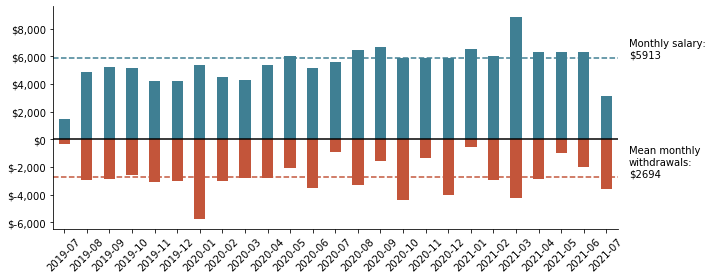

In [32]:
fig, ax = plt.subplots(figsize=(10, 4))

blue = sns.diverging_palette(220, 20)[0]
red = sns.diverging_palette(220, 20)[-1]

# Plot deposits positive
ax = monthly['deposit'].plot(kind='bar', ax=ax, color=blue)

# Plot withdrawals negative
ax = (-1*monthly['withdrawal']).plot(kind='bar', ax=ax, color=red)

# Add horizontal line at 0
ax.axhline(0, c='k')

# And for the average of my withdrawals, and my monthly salary for deposits
mean_withdrawals = monthly.mean()['withdrawal']
ax.axhline(-1*mean_withdrawals, c=red, linestyle='--')
ax.text(25, -mean_withdrawals, f'Mean monthly\nwithdrawals:\n${mean_withdrawals:.0f}')

# Salary after taxes and savings are removed
salary = 2*2956.40
ax.axhline(salary, c=blue, linestyle='--')
ax.text(25, salary, f'Monthly salary:\n${salary:.0f}')

# Format axes
_ = ax.set_xticklabels(monthly.index.strftime('%Y-%m'), rotation=45)
_ = ax.set_yticklabels(['${:,.0f}'.format(y) for y in ax.get_yticks()])
ax.set_xlabel('')

sns.despine()

fig.tight_layout()

\\$3,219 leftover each month. Mortgage (including taxes) for this house is \$2,983.

So I can save \$300/month, if Ben doesn't contribute at all to the mortgage.

---

Ok that looks a lot more reasonable now.

Interestingly, my expenses haven't really gotten much lower since moving to New Hampshire. Looks like I had an average of ~$3000-$3500 per month (except Jan 2020, which is probably bc that's from my trip to San Diego and SF with Ben and my family, so that's probably flights plus our few days in SF?).

Covid hit in March and things really closed down late March, so the lower April spending would have been reflected in my May credit card statement. You do see a slight dip in May. Then an uptick in June, when I donated a lot of money to causes. July is very low; that was a dark month with a lot of nothing. 

August spikes back up because of moving costs; we moved to NH then. Interestingly there's this two month pattern -- I think this was me and Ben auto-correcting for splitting moving expenses. For example, I bought a lot of the big stuff like our fridge and toaster oven. We spent about $6k in total for moving expenses, I think.

I also got Christmas gifts a little early, so that may be the October spike. And I bought a couch in December, so that's likely that!

Interestingly, my expenses are back up to \\$3000 the last two months. I wonder if this is because Ben has been using my credit card for all of our meal kits, and I've been paying for most of the groceries? We do pay for two meal kit subscriptions (hey, don't judge - our kitchen is tiny and miserable to cook in. This has been the most sustainable solution), but there's no way that's it?

Oh wait, duh. No it's because I bought a car so now I have an additional \\$460 monthly payment. I also got Ben an ice cream maker for his bday, which I guess would be reflected in the March expenses bc it was on my Feb credit card statement. And in Feb I also paid an extra ~$500 to register my car in New Hampshire.

I wonder if next month's expenses will go back down to "normal" NH levels? Though tbh, given that we're looking to move it doesn't seem like moving to New Hampshire saved me any money!! My average expenses are basically what they were back in Boston, just a little spikier...

